In [1]:
import numpy as np
from skimage.filters import gaussian
import cv2 
import matplotlib.pyplot as plt
import pylab as pl

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)
from tifffile import imread, imsave
import bobsegutils as bsu
from scipy.spatial.distance import euclidean
import csv
import math
from lm_tm import *
from MSER_kNN import mser_nearest

Populating the interactive namespace from numpy and matplotlib


In [2]:
def subVector(vec1, vec2):
    """Makes a vector given two points using B-A given the coordinates of two points A and B
       Parameters: Two lists of vectors
       Returns a list
    """
    return [(vec2[0] - vec1[0], vec2[1] - vec1[1]) for vec1, vec2 in zip(vec1, vec2)] 

In [3]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  
    """
    return vector / np.linalg.norm(vector)
def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [4]:
def parameter_dependent_compute_flow( flowchannel, pyramid_scale, pyramid_levels, window_size, loops, polygons_n, polygons_sigma ):
    '''Computes the Farneback dense flow for the given movie based on passed parameters
    '''
    flows = []
    prvs = flowchannel[0]
    for f in range(flowchannel.shape[0]):
        nxt = flowchannel[f]
        flow = cv2.calcOpticalFlowFarneback(prev=prvs,
                                            next=nxt,
                                            flow=None,
                                            pyr_scale=pyramid_scale, 
                                            levels=pyramid_levels,
                                            winsize=window_size,
                                            iterations=loops,
                                            poly_n=polygons_n, 
                                            poly_sigma=polygons_sigma, 
                                            flags=0)
        flows.append(flow)
        prvs = nxt
        print ('.', end="")
    print (' ...done!')
    return flows

In [5]:
def computeFlowMetric(test_set, avg_flow_x, avg_flow_y):

    flow_vectors_computed = []
    for vec in range(len(test_set)):
        int_x = int(round(test_set[vec][0]))
        int_y = int(round(test_set[vec][1]))
        time = int(test_set[vec][4])
        computed_u = avg_flow_x[time][int_y][int_x]
        computed_v = avg_flow_y[time][int_y][int_x]
        flow_vectors_computed.append((int_x, int_y, computed_u, computed_v, time))

    final_coordinates_gt = []
    final_coordinates_computed = []
    initial_coordinates = []
    for i in range(len(test_set)):

        final_coordinates_gt.append((test_set[i][0]+test_set[i][2], test_set[i][1]+test_set[i][3]))
        final_coordinates_computed.append((flow_vectors_computed[i][0]+flow_vectors_computed[i][2], flow_vectors_computed[i][1]+flow_vectors_computed[i][3]))
        initial_coordinates.append((test_set[i][0],test_set[i][1]))

    epe = []
    angle= []
    for i in range(len(flow_vectors_computed)):
        u = flow_vectors_computed[i][2]
        v = flow_vectors_computed[i][3]
        u0 = test_set[i][2]
        v0 = test_set[i][3]
        end_point_error=((u-u0)**2+(v-v0)**2)**0.5
        angle_error=angle_between((final_coordinates_computed[i]),( final_coordinates_gt[i]))*180/math.pi
        epe.append(end_point_error)
        angle.append(angle_error)
    return (epe, angle, np.mean(epe))

### Reads noisy image, denoised image and the corresponding csv file for tracklets to serve as GT

In [6]:
base_path = "/Users/prakash/Downloads/Junction_Coupling_Analysis/MAX_20190503_LP823_03-01/"
denoised_image_file_name = base_path+'MAX_20190503_LP823_03-01_Myo_denoised.tif'
csv_path = base_path+'MAX_20190503_LP823_03-01_tracklets.csv'
denoised_image = imread(denoised_image_file_name)
print('Shape of stack:', denoised_image.shape)
if((denoised_image.ndim) == 4):
    denoised_image = denoised_image[:,:,:,0]
    print(denoised_image.shape)

Shape of stack: (61, 472, 737, 1)
(61, 472, 737)


### Extract flow vectors from tracklets in csv file

In [7]:
### Read the results csv file, delete all entries which are not coordinates and write it as a new csv file
puncta = []
edges = []
with open(csv_path,"r") as source:
    rdr= csv.reader( source )
    next(rdr)
    for line in source:
        if(line.startswith("edgep1,edgep2") ):
            break
        else:
            puncta.append(line[:-1])

edgeCount = False            
with open(csv_path,"r") as source:
    rdr= csv.reader( source )
    next(rdr)
    for line in source:
        if(line.startswith("edgep1,edgep2") ):
            edgeCount = True
        if(edgeCount):
            edges.append(line[:-1])
        

In [8]:
modified_edges = []
modified_puncta = []
for edge in range(1, len(edges)):
    modified_edges.append([float(edge) for edge in edges[edge].split(',')])
for punctum in range(len(puncta)):
    modified_puncta.append([float(punctum) for punctum in puncta[punctum].split(',')])

In [9]:
flow_vectors_gt = []
for edge in modified_edges:
    id1 = edge[0]
    id2 = edge[1]
    puncta1 = modified_puncta[int(id1)]
    puncta2 = modified_puncta[int(id2)]
    time_diff = np.abs(puncta1[-1] - puncta2[-1])
    if(puncta1[-1]<puncta2[-1] and time_diff ==1):
        time = int(puncta1[-1])
        x = puncta1[1]
        y = puncta1[2]
        u = puncta2[1] - puncta1[1]
        v = puncta2[2] - puncta1[2]
        
    elif(puncta2[-1]<puncta1[-1] and time_diff ==1):
        time = int(puncta2[-1])
        x = puncta2[1]
        y = puncta2[2]
        u = puncta1[1] - puncta2[1]
        v = puncta1[2] - puncta2[2]
    elif(puncta2[-1]==puncta1[-1]):
        continue
    flow_vectors_gt.append((x,y,u,v,time))

In [10]:
if len(set(flow_vectors_gt)) == len(flow_vectors_gt):
    print("no duplicates found!")

no duplicates found!


In [ ]:
test_frac = int(len(flow_vectors_gt)*0.2)
random.shuffle(flow_vectors_gt)
test_set = flow_vectors_gt[0:test_frac]
train_set = flow_vectors_gt[test_frac:]

In [ ]:
train_puncta = []
train_edges = []
iden = 0
for i in range(len(train_set)):
    x1 = train_set[i][0]
    y1 = train_set[i][1]
    time1 = int(train_set[i][4])
    x2 = x1+ train_set[i][2]
    y2 = y1+ train_set[i][3]
    time2 = time1+1
    computed_puncta1 = [iden, x1, y1, time1]
    computed_puncta1 = ','.join(map(str, computed_puncta1)) 
    computed_puncta2 = [iden+1, x2, y2, time2]
    computed_puncta2 = ','.join(map(str, computed_puncta2)) 
    train_puncta.append(computed_puncta1)
    train_puncta.append(computed_puncta2)
    iden+=2
train_puncta.insert(0, "id,x,y,t")

In [ ]:
train_edges = []
for i in range(0, len(train_puncta)-1, 2):
    computed_edge = [i, i+1]
    computed_edge = ','.join(map(str, computed_edge)) 
    train_edges.append(computed_edge)
train_edges.insert(0, "edgep1,edgep2")
full = [train_puncta, train_edges]
a = []
for x in full:
    for y in x:
        a.append(y)

In [ ]:
with open(base_path+ '/train_tracklets.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL,delimiter='\n')
    wr.writerow(a)

In [ ]:
np.save(base_path+"/test_set.npy", test_set)
# test_set = np.load(base_path+"/test_set.npy")

Now execute the GUI flow and save the flow image. Load it below.

In [11]:
test = np.load(base_path+"/test_set.npy.npz")

In [12]:
test_set = []
lst = test.files
for item in lst:
    i = [tuple(l) for l in test[item]]
    test_set.append(i)

In [13]:
test_set = test_set[0]

# Automated parameter selection for  Optical Flow

In [14]:
#Initial parameters for starting the grid search for optimal flow parameters
initial_pyramid_scale = 0.25
initial_pyramid_level = 1
initial_window_size = 3
initial_loops = 1
initial_polygons_n = 3
initial_polygons_sigma = 1

In [15]:
pyramid_scale = initial_pyramid_scale
pyramid_levels = initial_pyramid_level 
window_size = initial_window_size
loops = initial_loops
polygons_n = initial_polygons_n
polygons_sigma = initial_polygons_sigma
avg_epe = 10000000000000

while(pyramid_scale<=0.75):
    while(pyramid_levels<=3):
        while(window_size<=7):
            while(loops<=3):
                while(polygons_n<=5):
                    while(polygons_sigma<=1.4):
                        flows = parameter_dependent_compute_flow( denoised_image, pyramid_scale, pyramid_levels, window_size, loops, polygons_n, polygons_sigma )
                        flow_x, flow_y = bsu.split_flow_components( flows )
                        avg_flow_x = bsu.flow_average(flow_x, 1)
                        avg_flow_y = bsu.flow_average(flow_y, 1)
                        epe, angle, metric = computeFlowMetric(test_set, avg_flow_x, avg_flow_y)
                       
                        if (metric<avg_epe):
                            best_pyr_scale = pyramid_scale
                            best_levels = pyramid_levels
                            best_win_size = window_size
                            best_iterations = loops
                            best_poly_n = polygons_n
                            best_poly_sigma = polygons_sigma
                            avg_epe = metric
                            
                        polygons_sigma = polygons_sigma + 0.2
                        #print(polygons_sigma)
                        
                        
                    polygons_sigma = initial_polygons_sigma
                    polygons_n = polygons_n+1
                    #print(polygons_n)
                    
                polygons_n = initial_polygons_n
                loops = loops+1
                #print(loops)
                
            loops = initial_loops
            window_size = window_size+2
            #print(window_size)
            
        window_size = initial_window_size
        pyramid_levels = pyramid_levels +1
        #print(pyramid_levels)
        
        
    pyramid_levels =initial_pyramid_level
    pyramid_scale = pyramid_scale+0.25                        

............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
......

............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
......

............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
......

............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
......

............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
......

............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
......

............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
............................................................. ...done!
......

In [16]:
print("pyr_scale:", best_pyr_scale)
print("levels:", best_levels)
print("win_size:", best_win_size)
print("iterations:", best_iterations)
print("poly_n:", best_poly_n)
print("poly_sigma:",best_poly_sigma )
with open('Optical flow parameter.txt', 'w') as f:
    f.write("pyr_scale: %s" % best_pyr_scale)
    f.write("levels: %s" % best_levels)
    f.write("win_size: %s" % best_win_size)
    f.write("iterations: %s" % best_iterations)
    f.write("poly_n: %s" % best_poly_n)
    f.write("poly_sigma: %s" % best_poly_sigma)
    
    f.close()

pyr_scale: 0.5
levels: 2
win_size: 7
iterations: 1
poly_n: 3
poly_sigma: 1.4


In [14]:
flows = bsu.compute_flow( denoised_image )
flow_x, flow_y = bsu.split_flow_components( flows )
avg_flow_x = bsu.flow_average(flow_x, 1)
avg_flow_y = bsu.flow_average(flow_y, 1)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

Here, here!
............................................................. ...done!


In [15]:
epe, angle, m = computeFlowMetric(test_set, avg_flow_x, avg_flow_y)

In [16]:
print("OF-", np.mean(epe), np.std(epe), np.mean(angle), np.std(angle))

OF- 2.271660586475929 1.3391112893857091 0.15835566340116136 0.12486662143974914


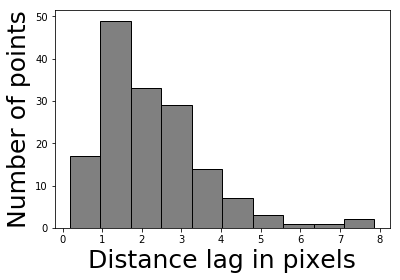

In [17]:
plt.hist(epe, histtype='bar', color='gray', ec='black')
plt.xlabel('Distance lag in pixels',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

In [ ]:
plt.hist(angle, bins=range(0,180,5), histtype='bar', color='gray', ec='black')
plt.xlabel('Angle lag in degrees',fontsize=25)
plt.ylabel('Number of points',fontsize=25)
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10)
plt.show()

### Export computed tracklets for visulaization in GUI

In [ ]:
iden = 0
visulaizatiuon_puncta = []
for i in range(len(flow_vectors_gt)):
    
    x1 = flow_vectors_gt[i][0]
    y1 = flow_vectors_gt[i][1]
    time1 = int(flow_vectors_gt[i][4])
    x2 = final_coordinates_computed[i][0]
    y2 = final_coordinates_computed[i][1]
    time2 = time1+1
    computed_puncta1 = [iden, x1, y1, time1]
    computed_puncta1 = ','.join(map(str, computed_puncta1)) 
    computed_puncta2 = [iden+1, x2, y2, time2]
    computed_puncta2 = ','.join(map(str, computed_puncta2)) 
    visulaizatiuon_puncta.append(computed_puncta1)
    visulaizatiuon_puncta.append(computed_puncta2)
    iden+=2
visulaizatiuon_puncta.insert(0, "id,x,y,t")

In [ ]:
visualization_edges = []
for i in range(0, len(visulaizatiuon_puncta), 2):
    computed_edge = [i, i+1]
    computed_edge = ','.join(map(str, computed_edge)) 
    visualization_edges.append(computed_edge)
visualization_edges.insert(0, "edgep1,edgep2")
full = [visulaizatiuon_puncta, visualization_edges]
a = []
for x in full:
    for y in x:
        a.append(y)

In [ ]:
with open(base_path+ '/OF_visualization_tracklets.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL,delimiter='\n')
    wr.writerow(a)